# Libraries

In [4]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import torch
import torch.nn as nn
# Defining the working directories

work_dir = '../input/cassava-leaf-disease-classification/'
json_path = '../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'
os.listdir(work_dir)
train_path = '/kaggle/input/cassava-leaf-disease-classification/train_images'

# Reading Data

In [5]:
# Importing Train Data

data = pd.read_csv(work_dir + 'train.csv')
print(Counter(data['label'])) # Checking the frequencies of the labels

Counter({3: 13158, 4: 2577, 2: 2386, 1: 2189, 0: 1087})


In [6]:
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [7]:
train_data=data.copy()
train_data.label = train_data.label.astype('str')
print(train_data.dtypes)

image_id    object
label       object
dtype: object


In [8]:
with open (json_path, 'r') as file:
    class_names = json.load(file)

#print id and class_names
class_names

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

# Visualization

In [ ]:
def visualize_images(data, row=1, col=3):
    fig, axes = plt.subplots(row, col, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.set_title(class_names[data.label[i]])
        img = load_img(train_path + "/" + data.image_id[i])
        img = img_to_array(img, dtype=np.uint8)
        ax.imshow(img)
        ax.axis('off')  # Turn off axis
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

In [ ]:
import pandas as pd

# Assuming 'label_column_name' is the name of your label column
grouped_data = train_data.groupby('label')

# Initialize an empty list to store the sampled data
sampled_data = []

# Iterate over each group, sample five random samples from each group, and append to sampled_data
for label, group in grouped_data:
    sampled_group = group.sample(min(2, len(group)))  # Sample up to five samples from each group
    sampled_data.append(sampled_group)

# Concatenate the sampled data into a single dataframe
sampled_data = pd.concat(sampled_data, ignore_index=True)

print(sampled_data)


In [ ]:
visualize_images(sampled_data,5,2)

# Train Val Split

In [9]:
#Importing the json file with labels

f = open(work_dir + 'label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

# Defining the working dataset

data['class_name'] = data.label.map(real_labels)

# Splitting the data

from sklearn.model_selection import train_test_split

train,val = train_test_split(data, test_size = 0.05, random_state = 42, stratify = data['class_name'])

# Importing the data using ImageDataGenerator

IMG_SIZE = 456
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 15

datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

train_set = datagen_train.flow_from_dataframe(train,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

val_set = datagen_val.flow_from_dataframe(val,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 20327 validated image filenames belonging to 5 classes.
Found 1070 validated image filenames belonging to 5 classes.


# Data Balancing

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
# Get labels from DataFrameIterator
labels = train_set.labels

# Count occurrences of each label
#label_counts = labels.value_counts()
series = pd.Series(labels)

# Now you can call value_counts() on the Series
label_counts = series.value_counts()
# Plot the counts
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
label_counts

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Assuming train is your DataFrame with 'image_id' and 'class_name' columns
# and train_path is the path to your training images directory

# Define the parameters
IMG_SIZE = 456
size = (IMG_SIZE, IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 15

# Create the data generators
datagen_train = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Count the number of samples for each class
class_counts = train['class_name'].value_counts()

# Determine the class with the fewest samples
min_class_samples = class_counts.min()

# Create a balanced dataset by randomly selecting an equal number of samples from each class
balanced_train = pd.DataFrame()

for class_label in class_counts.index:
    # Select a subset of the samples for the current class
    class_subset = train[train['class_name'] == class_label]

    # Randomly select 'min_class_samples' number of samples
    balanced_subset = class_subset.sample(n=min_class_samples, replace=False)

    # Ensure that balanced_subset is a DataFrame
    if not isinstance(balanced_subset, pd.DataFrame):
        balanced_subset = pd.DataFrame(balanced_subset)

    # Append the balanced subset to the balanced DataFrame
    balanced_train = pd.concat([balanced_train, balanced_subset], ignore_index=True)

# Shuffle the balanced DataFrame
balanced_train = balanced_train.sample(frac=1).reset_index(drop=True)

# Create a new DataFrameIterator with the balanced DataFrame
balanced_train_set = datagen_train.flow_from_dataframe(
    dataframe=balanced_train,
    directory=train_path,
    x_col='image_id',
    y_col='class_name',
    target_size=size,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Now you can use train_set for training your model

Found 5165 validated image filenames belonging to 5 classes.


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
# Get labels from DataFrameIterator
labels = balanced_train_set.labels

# Count occurrences of each label
#label_counts = labels.value_counts()
series = pd.Series(labels)

# Now you can call value_counts() on the Series
label_counts = series.value_counts()
# Plot the counts
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Model

In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

model = Sequential()
# initialize the model with input shape
model.add(EfficientNetB3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                         weights = 'imagenet',
                         drop_connect_rate=0.6))
#for layer in model.layers[:-40]:  # Training just part of the architecture do not optimize the performance
#    layer.trainable = False
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model.add(Dropout(0.5))
model.add(Dense(n_CLASS, activation = 'softmax'))

model.summary()

In [ ]:
keras.utils.plot_model(model)

In [ ]:
EPOCHS = 15
STEP_SIZE_TRAIN = balanced_train_set.n//balanced_train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )

model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'

In [ ]:
# We Create a ModelCheckpoint callback to save the best model based on validation accuracy
from tensorflow.keras.callbacks import ModelCheckpoint
metric = 'val_categorical_accuracy'
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor=metric, save_best_only=True)

In [ ]:
#categorical_accuracy for balanced dataset
history = model.fit(balanced_train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[checkpoint])

In [ ]:
import keras

model = keras.models.load_model('/kaggle/input/balanced-data-model/best_model_balanced.h5')

In [ ]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(val_set)

# Categorical_crossentropy

In [ ]:
#categorical_accuracy
history = model.fit(train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID)

# History Plot

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(model.history.history['accuracy'],model.history.history['val_accuracy'],
               model.history.history['loss'],model.history.history['val_loss'])

# Taylor cross entropy loss

In [ ]:
# Taylor cross entropy loss
def taylor_cross_entropy_loss(y_pred, y_true, n=3, label_smoothing=0.0):
    """Taylor Cross Entropy Loss.
    Args:
    y_pred: A multi-dimensional probability tensor with last dimension `num_classes`.
    y_true: A tensor with shape and dtype as y_pred.
    n: An order of taylor expansion.
    label_smoothing: A float in [0, 1] for label smoothing.
    Returns:
    A loss tensor.
    """
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    if label_smoothing > 0.0:
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        y_true = (1 - num_classes /(num_classes - 1) * label_smoothing) * y_true + label_smoothing / (num_classes - 1)

    y_pred_n_order = tf.math.maximum(tf.stack([1 - y_pred] * n), 1e-7) # avoide being too small value
    numerator = tf.math.maximum(tf.math.cumprod(y_pred_n_order, axis=0), 1e-7) # avoide being too small value
    denominator = tf.expand_dims(tf.expand_dims(tf.range(1, n+1, dtype="float32"), axis=1), axis=1)
    y_pred_taylor = tf.math.maximum(tf.math.reduce_sum(tf.math.divide(numerator, denominator), axis=0), 1e-7) # avoide being too small value
    loss_values = tf.math.reduce_sum(y_true * y_pred_taylor, axis=1, keepdims=True)
    return tf.math.reduce_sum(loss_values, -1)

class TaylorCrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, n=3, label_smoothing=0.0):
        super(TaylorCrossEntropyLoss, self).__init__()
        self.n = n
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        return taylor_cross_entropy_loss(y_pred, y_true, n=self.n, label_smoothing=self.label_smoothing)

In [ ]:
loss = TaylorCrossEntropyLoss(n=3)

model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'

In [ ]:
#Taylor Cross Entropy train on imbalaced dataset
history = model.fit(train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID)

# Accuracy 0.8897

In [ ]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(val_set)

In [ ]:
model.save('Cassava_model_taylor_model'+'.h5')

# Testing The Model

In [ ]:
import keras

model = keras.models.load_model('/kaggle/input/cassava-model/Cassava_best_model.h5')

In [ ]:
TEST_DIR = '../input/cassava-leaf-disease-classification/test_images/'
test_images = os.listdir(TEST_DIR)
datagen = ImageDataGenerator(horizontal_flip=True)


def pred(images):
    for image in test_images:
        img = Image.open(TEST_DIR + image)
        img = img.resize(size)
        samples = np.expand_dims(img, axis=0)
        it = datagen.flow(samples, batch_size=10)
        yhats = final_model.predict_generator(it, steps=10, verbose=0)
        summed = np.sum(yhats, axis=0)
    return np.argmax(summed)

predictions = pred(test_images)

In [ ]:
# Creating the CSV for final submission

sub = pd.DataFrame({'image_id': test_images, 'label': predictions})
display(sub)
#sub.to_csv('submission.csv', index = False)

#  Fliping Code

In [ ]:
noisy_train = balanced_train.copy()
noisy_train['label']=flipped_labels

# Other Label Noise Techniques

In [ ]:
def add_noise(df_orginal, noise_level):
    df = df_orginal.copy()
    num_noisy = int(len(df) * noise_level / 100)
    indices = np.random.choice(df.index, size=num_noisy, replace=False)
    #df.loc[indices, 'label'] = np.random.randint(0, 5)  #[0.4383177570093458, 0.34392523364485983,0.4093457943925234,0.3383177570093458]
    df.loc[indices, 'label'] = -200 #[0.35046728971962615, 0.3981308411214953,0.2869158878504673,0.3728971962616822]
    return df

In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Percentages of noise to introduce
noise_percentages = [5, 10, 15, 20]

# Lists to store accuracy before and after noise
accuracy_before_noise = []
accuracy_after_noise = []

# Train the model and evaluate accuracy for different noise levels
for noise_percentage in noise_percentages:
    # Introduce noise to labels in the training set
    noisy_train = add_noise(balanced_train, noise_percentage)

    # Create new DataFrameIterators with the noisy labels
    noisy_train_set = datagen_train.flow_from_dataframe(noisy_train,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

    # Train the model on the noisy labels
    model.fit(noisy_train_set, epochs=3, verbose=0)  # Train for one epoch for demonstration purposes

    # Predict the validation set and calculate accuracy
    y_pred_noisy = model.predict(val_set)
    y_true = val_set.classes
    y_pred_classes = np.argmax(y_pred_noisy, axis=1)
    accuracy_after_noise.append(accuracy_score(y_true, y_pred_classes))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(noise_percentages, accuracy_after_noise, label='Accuracy After Noise')
plt.xlabel('Noise Percentage')
plt.ylabel('Accuracy')
plt.title('Effect of Label Noise on Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("rand_filp_Noisy.png")

In [ ]:
accuracy_after_noise

# Impact flip

In [ ]:
type(train_set)

In [ ]:
pip install tensorflow==2.9.1

In [15]:
import tensorflow as tf
model = tf.keras.models.load_model('/kaggle/input/cassava/Cassava_best_model.h5')

In [16]:
predictions = model.predict(balanced_train_set)

345/345 [==============================] - 1709s 5s/step


In [17]:
predicted_classes = np.argmax(predictions, axis=1)
confidences = np.max(predictions, axis=1)

In [18]:
predicted_classes

array([0, 1, 2, ..., 0, 2, 0])

In [19]:
true_labels = balanced_train_set.labels
true_labels = np.array(true_labels)

In [20]:
true_labels

array([4, 4, 3, ..., 0, 1, 3])

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
num_classes=5
# Calculate the accuracy of the model
accuracy = accuracy_score(true_labels, predicted_classes)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix to understand the type of errors
conf_matrix = confusion_matrix(true_labels, predicted_classes)
print(f'Confusion Matrix:\n{conf_matrix}')

# Flip the labels of the instances with the confidence score greater than 80%
flipped_labels = true_labels.copy()
threshold = 0.80  # Flip labels where the confidence score is greater than 80%
flipped_labels[confidences > threshold] = (true_labels[confidences > threshold] + 1) % num_classes
noisy_train = balanced_train.copy()
noisy_train['label']=flipped_labels
# Create new DataFrameIterators with the noisy labels
noisy_train_set = datagen_train.flow_from_dataframe(noisy_train,
                         directory = train_path,
                         seed=42,
                         x_col = 'image_id',
                         y_col = 'class_name',
                         target_size = size,
                         #color_mode="rgb",
                         class_mode = 'categorical',
                         interpolation = 'nearest',
                         shuffle = True,
                         batch_size = BATCH_SIZE)

# Train the model on the noisy labels
model.fit(noisy_train_set, epochs=3, verbose=0)  # Train for one epoch for demonstration purposes

# Predict the validation set and calculate accuracy
y_pred_noisy = model.predict(val_set)
y_pred_classes = np.argmax(y_pred_noisy, axis=1)
# Calculate the accuracy of the model with flipped labels
flipped_accuracy = accuracy_score(true_labels, y_pred_classes)

print(f'Model Accuracy with Flipped Labels: {flipped_accuracy * 100:.2f}%')


Model Accuracy: 21.18%
Confusion Matrix:
[[177 186 186 267 217]
 [184 209 176 246 218]
 [177 178 206 256 216]
 [178 179 201 279 196]
 [181 205 203 221 223]]
Model Accuracy with Flipped Labels: 35.35%


# Fliping Detection

In [24]:
import pandas as pd
from keras.models import load_model

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['image_id', 'original_label', 'predicted_label','Flipped Label', 'score'])

# Use concat to add rows to the DataFrame
new_rows = pd.DataFrame({
    'image_id': balanced_train['image_id'],
    'original_label': balanced_train['label'],
    'predicted_label': predicted_classes,
    'Flipped Label': flipped_labels,
    'score': confidences
})
results_df = pd.concat([results_df, new_rows], ignore_index=True)

# Save the DataFrame to a CSV file
results_df.to_csv('predictions.csv', index=False)


/tmp/ipykernel_110/1141290627.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_rows], ignore_index=True)


In [25]:
results_df.head()

,image_id,original_label,predicted_label,Flipped Label,score
0,1996031857.jpg,4,0,4,0.484787
1,3169385678.jpg,4,1,0,0.835544
2,3953530273.jpg,3,2,4,0.891690
3,3008060354.jpg,3,3,4,0.984533
4,698646619.jpg,4,1,0,0.989478


In [2]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/kaggle/input/prdictioons/predictions.csv')

# Filter the rows
filtered_df = df[(df['score'] > 0.90) & (df['original_label'] == df['predicted_label']) & (df['original_label'] != df['Flipped Label'])]

# Display the filtered rows
print(filtered_df)

            image_id  original_label  predicted_label  Flipped Label     score
3     3008060354.jpg               3                3              4  0.984533
10     622587109.jpg               3                3              4  0.977505
18    1256756297.jpg               2                2              3  0.977394
21    1213348737.jpg               2                2              3  0.989632
29     336083586.jpg               1                1              2  0.984263
...              ...             ...              ...            ...       ...
5130  1739927380.jpg               1                1              2  0.951466
5132  3074981220.jpg               0                0              1  0.909298
5143  2853469251.jpg               2                2              3  0.927316
5148  1713720885.jpg               3                3              4  0.983752
5159  3186872066.jpg               2                2              3  0.987802

[589 rows x 5 columns]


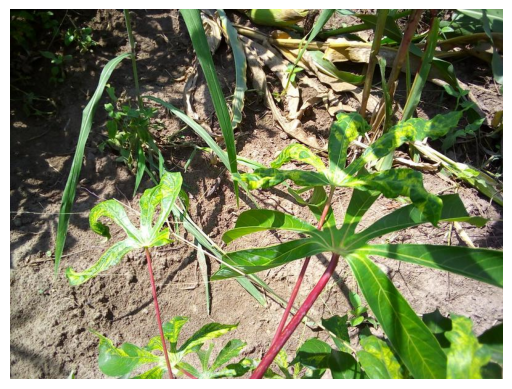

Current flipped label: 4


KeyboardInterrupt: Interrupted by user

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Function to display an image and ask for user input
def correct_label(image_id, original_label, flipped_label):
    # Assuming the images are in a directory named 'images'
    image_path = f'{train_path}/{image_id}'
    
    # Display the image
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Optional: to remove axis from the image
    plt.show()
    
    # Ask the user to input the correct flipped label
    print(f"Current flipped label: {flipped_label}")
    new_label = input(f"Please enter the correct flipped label for image {image_id} (or press Enter to keep the current label): ")
    
    # If the user enters a new label, update the DataFrame
    if new_label:
        df.loc[df['image_id'] == image_id, 'Flipped Label'] = new_label

# Iterate over the filtered DataFrame and correct labels
for index, row in filtered_df.iterrows():
    correct_label(row['image_id'], row['original_label'], row['Flipped Label'])

# Save the updated DataFrame to a new CSV file
df.to_csv('updated_file.csv', index=False)